In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv1_F11_small/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11_small/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw1_F11_small/plots_meas'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'dvar')
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
dvar_meas = pd.read_hdf(meas_datafile,'param')

qoi_meas = pd.read_hdf(meas_datafile,'qoi')

qoi_meas



F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.898133     9.812126     9.780692     9.713143  ...   
1     294.33823   274.810342   273.276961   267.670406    256.42997  ...   
2     138.89772   147.105122    133.24079   114.931483   109.322211  ...   
3     181.56351   157.498141    131.03587   101.940804    72.543582  ...   
4     119.35442    71.961964    57.870742    49.497148    41.000065  ...   
5     11.484595    11.318596    11.203328    11.143059    11.132492  ...   
6     29.841686    29.746688     29.56951    29.268835    28.897714  ...   
7     72.211281    65.265902    64.064075    63.030589    62.087433  ...   
8      149.0925   139.418343   136.915128   135.413765   133.908431  ...   
9     119.41093   114.638491   112.756318    110.20757   107.400512  ...   
10    237.04869    213.72616    209.10027   206.119219   200.170367  ...   
11    171.20494   158.477975   153.810887   146.616963   139.183722  ...   
12    315.74103   292.228769   284.521563   260.474723    240.43224  ...   
13    99.863449    94.076989    90.692855    81.414035    68.016267  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.061826      0.057134      0.052089      0.040751      0.040911   
1      -0.441232     -0.401337     -0.368562     -0.334364     -0.309479   
2      -0.741377     -0.693725     -0.681174     -0.632558     -0.602007   
3      -0.575589     -0.536714     -0.507962     -0.553993     -0.525728   
4      -0.523141      -0.50454     -0.472679     -0.416469     -0.317612   
5       0.081484      0.078445      0.070497       0.06563      0.061137   
6       0.152212      0.129584      0.104234      0.093521      0.085057   
7      -0.066784     -0.085836     -0.094277     -0.059041     -0.053655   
8       0.020547      0.022647      0.022047      0.016791       0.03127   
9       0.250642      0.212366      0.177127      0.172673      0.174824   
10     -0.093295     -0.077207     -0.074237     -0.087953     -0.076371   
11      0.002308      0.013184      0.001364      -0.03792     -0.012979   
12      0.136368      0.122509      0.104022      0.090523      0.108632   
13      0.055255     -0.011847     -0.014415      0.085851     -0.048677   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
#qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

#qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
#qoi_meas_preprocessed


meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
qoi_meas_preprocessed

F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.907636     9.838376     9.765396     9.688802  ...   
1     294.33823    286.71097    278.78708    270.60162    262.19009  ...   
2     138.89772    134.01062    128.97156    123.80804    118.54761  ...   
3     181.56351    167.37581    153.37401    139.69453    126.46206  ...   
4     119.35442    98.925941     80.22715    63.481689    48.849827  ...   
5     11.484595    11.418749    11.349015    11.275488    11.198265  ...   
6     29.841686    29.619547    29.384605    29.137228    28.877802  ...   
7     72.211281    71.364807     70.47345    69.539268    68.564407  ...   
8      149.0925    146.91719    144.63177    142.24245    139.75555  ...   
9     119.41093    117.29861    115.08589    112.77979     110.3875  ...   
10    237.04869    231.05679     224.8233    218.37454    211.73721  ...   
11    171.20494    165.40796    159.42224    153.27936    147.01094  ...   
12    315.74103    301.44171    286.83267    272.00998    257.06799  ...   
13    99.863449    92.011734    84.233818    76.601868    69.181999  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.081034      0.072851      0.065115      0.057823      0.050974   
1      -0.442524     -0.400883     -0.360518     -0.321694     -0.284636   
2      -0.660275     -0.611036     -0.558628     -0.504535      -0.45013   
3      -0.638159     -0.609828      -0.56966     -0.521175     -0.467822   
4      -0.580507     -0.558302     -0.522558     -0.474301     -0.417153   
5       0.068454      0.061512      0.054955       0.04878      0.042984   
6       0.117186      0.105547      0.094501      0.084052      0.074205   
7      -0.167922     -0.151881     -0.136464     -0.121726     -0.107716   
8       0.011969      0.013367      0.014146      0.014395        0.0142   
9       0.192151      0.175165      0.158521      0.142335      0.126713   
10     -0.087538     -0.083462     -0.078723     -0.073427     -0.067688   
11     -0.050779     -0.041434     -0.032962     -0.025375     -0.018693   
12      0.166831      0.153275      0.139661      0.126198      0.113069   
13      0.040776       0.05445      0.071118       0.09077        0.1131   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

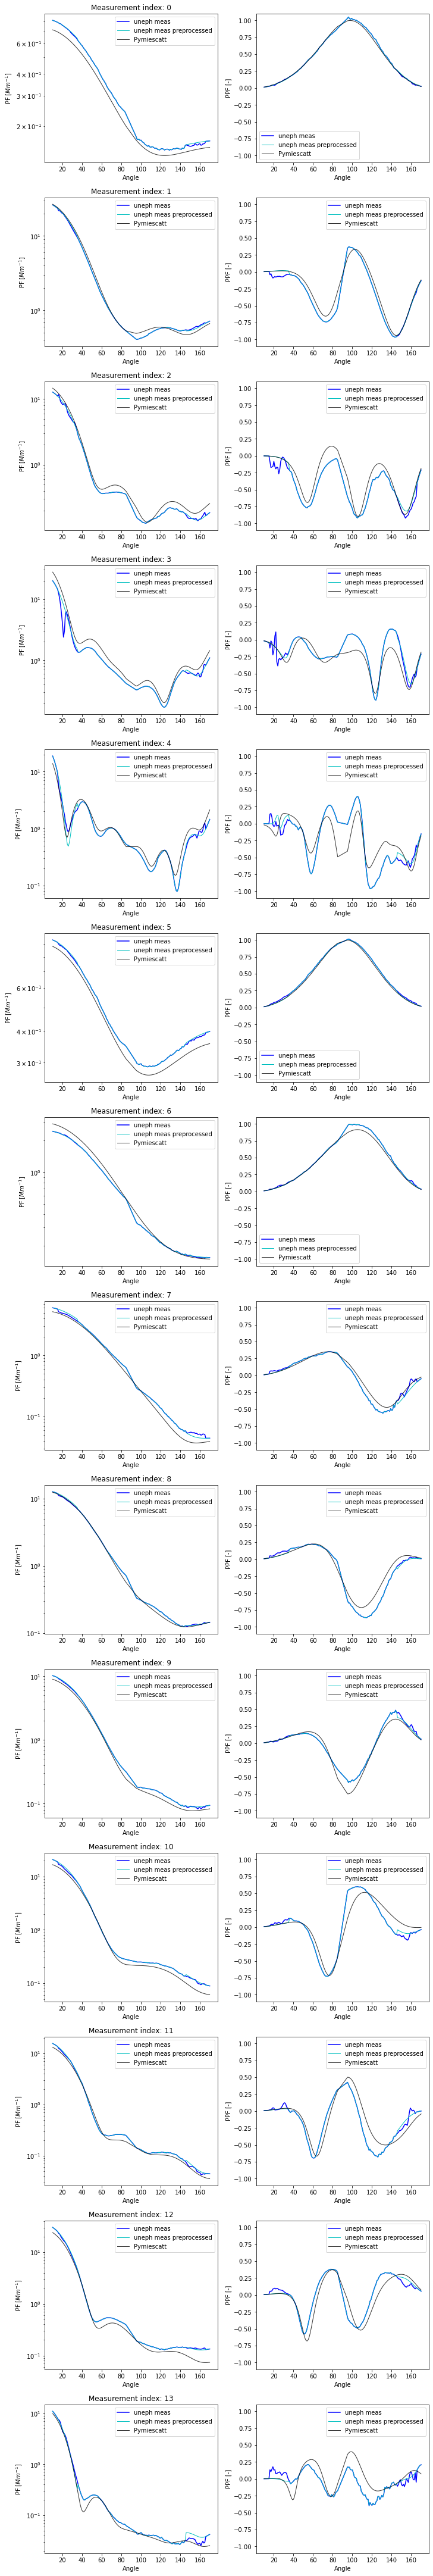

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.153705      3.085057      3.079462      3.058732      3.015831  ...   
2       2.402714      2.460123      2.361134      2.213312      2.163275  ...   
3       2.670581      2.528389      2.344447      2.093368      1.753163  ...   
4       2.251073      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.090018     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.864882      0.861694      0.855720      0.845499      0.832738  ...   
7       1.748572      1.647445      1.628860      1.612596      1.597519  ...   
8       2.473543      2.406455      2.388337      2.377311      2.366132  ...   
9       2.251546      2.210759      2.194205      2.171341      2.145541  ...   
10      2.937241      2.833671      2.811790      2.797430      2.768145  ...   
11      2.611837      2.534591      2.504700      2.456799      2.404771  ...   
12      3.223898      3.146513      3.119785      3.031482      2.951414  ...   
13      2.072779      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141       -0.50454      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497        0.06563       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791        0.03127   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364       -0.03792      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [17]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas[F11_columns_meas].values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0   0.985630  0.102520  1.068499  1.551424  0.054049
1   3.640170  0.244447  1.033557  1.637544  0.006172
2   1.231367  0.314374  1.051687  1.682632  0.013608
3   3.600674  0.526049  1.125788  1.643405  0.002000
4   4.197022  0.534468  1.063631  1.667938  0.022371
5   2.467149  0.079985  1.063673  1.589067  0.080663
6   1.927118  0.120753  1.049600  1.584701  0.229146
7   2.418234  0.149812  1.137906  1.555512  0.154096
8   3.938002  0.179416  1.096091  1.510358  0.282226
9   2.540837  0.205593  1.104332  1.599831  0.272034
10  4.745148  0.239157  1.086353  1.569864  0.375341
11  2.866666  0.290460  1.070707  1.620102  0.188818
12  4.764716  0.332587  1.060177  1.535255  0.206886
13  1.807834  0.413629  1.157136  1.540031  0.214962

In [18]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n         k
0  -0.014474  4.630054 -2.680931 -1.507676 -2.917863
1   1.292030  5.498997 -3.394503 -1.179137 -5.087655
2   0.208125  5.750584 -2.962550 -1.042330 -4.297070
3   1.281121  6.265394 -2.073157 -1.160260 -6.214389
4   1.434375  6.281272 -2.754656 -1.084894 -3.799977
5   0.903063  4.381844 -2.754000 -1.350669 -2.517481
6   0.656026  4.793748 -3.003764 -1.367667 -1.473396
7   0.883038  5.009379 -1.981183 -1.489380 -1.870180
8   1.370673  5.189710 -2.342459 -1.712812 -1.265047
9   0.932494  5.325900 -2.260174 -1.309960 -1.301829
10  1.557123  5.477120 -2.449313 -1.427684 -0.979920
11  1.053150  5.671467 -2.649213 -1.237522 -1.666971
12  1.561238  5.806902 -2.810461 -1.583503 -1.575590
13  0.592130  6.024968 -1.850643 -1.560502 -1.537295

In [19]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed[F11_columns_meas].values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0   0.986019  0.102186  1.074324  1.551328  0.031552
1   3.662605  0.241954  1.029891  1.595532  0.006266
2   1.196950  0.305589  1.039996  1.738004  0.013663
3   2.359766  0.400038  1.085197  1.606863  0.000848
4   4.887667  0.475894  1.038032  1.571741  0.020053
5   2.413662  0.080123  1.065121  1.596800  0.087326
6   1.951130  0.120679  1.049447  1.578040  0.205247
7   1.946421  0.155482  1.084272  1.576673  0.265949
8   3.969986  0.179066  1.114054  1.507559  0.256650
9   2.481290  0.205259  1.106908  1.548485  0.235493
10  4.702831  0.232227  1.076339  1.543984  0.357751
11  2.898908  0.289065  1.062365  1.694319  0.228121
12  4.977624  0.334667  1.049853  1.545707  0.199767
13  1.598579  0.406698  1.116970  1.535031  0.202123

In [20]:
F11_columns = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]

In [21]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt[F11_columns].values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0   0.949709  0.099391  1.064475  1.573856  0.076794
1   3.164892  0.241493  1.044917  1.563229  0.002607
2   1.222865  0.305874  1.046924  1.599199  0.002323
3   3.246118  0.383993  1.075178  1.552698  0.002154
4   5.721255  0.477018  1.051594  1.641311  0.003371
5   2.230821  0.081445  1.062765  1.593796  0.075162
6   2.167527  0.120555  1.061183  1.561561  0.175637
7   1.888032  0.150679  1.069876  1.612786  0.247699
8   3.482732  0.182470  1.080656  1.584307  0.252587
9   2.150173  0.197284  1.068180  1.544058  0.224993
10  3.358387  0.229154  1.085060  1.614483  0.206503
11  2.543564  0.271234  1.070070  1.657747  0.236361
12  4.654397  0.310529  1.073705  1.635826  0.215216
13  1.975898  0.406796  1.082936  1.655708  0.230113

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [22]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.708613  5.986968 -2.302585 -1.237874 -1.500584

In [23]:
F11_columns

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

In [24]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = F11_columns)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.147902 -0.151788 -0.136512 -0.153727 -0.188668 -0.229379 -0.246508   
1   3.451708  3.398127  3.352206  3.296641  3.237845  3.186793  3.123486   
2   2.573749  2.571308  2.558162  2.493197  2.474294  2.417523  2.355327   
3   3.269382  3.240037  3.213360  3.106437  3.040758  2.996610  2.892821   
4   3.053136  2.965163  2.873303  2.698853  2.545882  2.437320  2.273997   
5  -0.144780 -0.130050 -0.126447 -0.123424 -0.145798 -0.141915 -0.159129   
6   1.068554  1.060416  1.049072  1.037328  1.022054  1.011939  1.002949   
7   1.657390  1.645095  1.637036  1.621449  1.613666  1.605354  1.595944   
8   2.534924  2.522064  2.514013  2.496596  2.481780  2.471762  2.449293   
9   2.203938  2.186516  2.173922  2.150409  2.140601  2.131618  2.102463   
10  2.864742  2.836916  2.810831  2.782622  2.753352  2.728437  2.695920   
11  2.565882  2.538508  2.512387  2.488640  2.466645  2.435110  2.405462   
12  3.163317  3.137408  3.107802  3.067403  3.031846  2.993405  2.941553   
13  2.321912  2.273228  2.228162  2.165178  2.089731  2.025430  1.937102   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.296012 -0.285969 -0.308583  ... -1.680705 -1.747563 -1.729351 -1.755922   
1   3.090921  3.092450  3.069840  ... -0.498267 -0.535710 -0.482259 -0.450100   
2   2.280925  2.217897  2.163283  ... -1.615592 -1.626728 -1.564720 -1.538210   
3   2.802828  2.715815  2.621563  ... -0.386044 -0.390994 -0.318271 -0.262092   
4   2.103267  1.957801  1.786452  ...  0.031179  0.031240  0.129750  0.208327   
5  -0.178033 -0.183820 -0.199407  ... -1.031099 -1.026442 -1.023368 -1.019612   
6   0.987315  0.984026  0.976539  ... -1.886539 -1.884024 -1.892004 -1.889191   
7   1.586240  1.567539  1.554369  ... -3.311662 -3.308436 -3.302628 -3.299172   
8   2.427362  2.404871  2.385571  ... -1.983334 -1.974431 -1.966653 -1.960101   
9   2.075184  2.050332  2.022144  ... -2.521959 -2.523939 -2.521708 -2.516799   
10  2.662170  2.631126  2.601857  ... -2.789540 -2.805703 -2.822379 -2.831735   
11  2.374142  2.333943  2.303049  ... -3.107615 -3.122712 -3.134314 -3.140408   
12  2.892567  2.842875  2.800127  ... -2.676833 -2.701145 -2.711861 -2.723818   
13  1.845142  1.751562  1.656612  ... -3.754030 -3.765473 -3.782376 -3.810176   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.750711 -1.723687 -1.744085 -1.755195 -1.737566 -1.778010  
1  -0.474770 -0.442008 -0.406383 -0.429427 -0.425741 -0.431200  
2  -1.537282 -1.506155 -1.486519 -1.518508 -1.436298 -1.436164  
3  -0.242280 -0.153307 -0.058991 -0.058024  0.028711  0.079078  
4   0.259875  0.394182  0.523792  0.545667  0.674115  0.748227  
5  -1.016476 -1.005612 -1.007790 -1.001256 -0.998288 -0.998335  
6  -1.883755 -1.886907 -1.893134 -1.890603 -1.896677 -1.900641  
7  -3.294327 -3.288816 -3.274569 -3.272955 -3.265085 -3.259247  
8  -1.950205 -1.943186 -1.933815 -1.926715 -1.928932 -1.918644  
9  -2.509947 -2.512554 -2.494985 -2.499569 -2.499817 -2.486965  
10 -2.842860 -2.852764 -2.862226 -2.867503 -2.875733 -2.876722  
11 -3.157112 -3.172360 -3.182573 -3.183144 -3.189229 -3.188751  
12 -2.736671 -2.750435 -2.752318 -2.760711 -2.753441 -2.755889  
13 -3.812812 -3.810887 -3.817915 -3.826648 -3.817188 -3.813085  

[14 rows x 152 columns]

In [25]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = F11_columns)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.266410 -0.272436 -0.279857 -0.293249 -0.302774 -0.311461 -0.316988   
1   3.484574  3.449343  3.449103  3.449460  3.428985  3.408881  3.384027   
2   2.359182  2.308807  2.277858  2.239548  2.184305  2.143649  2.105394   
3   2.589784  2.494682  2.370845  2.255828  2.108393  1.936845  1.742193   
4   2.671801  2.568380  2.449301  2.299642  2.157886  1.976371  1.781583   
5  -0.034201 -0.039058 -0.039771 -0.044764 -0.053168 -0.058567 -0.062547   
6   0.946706  0.929458  0.920537  0.900230  0.887626  0.883053  0.879437   
7   1.634682  1.623794  1.615258  1.600008  1.592633  1.577917  1.560903   
8   2.261877  2.247371  2.251479  2.236695  2.226003  2.216165  2.196160   
9   2.277881  2.258649  2.246298  2.226828  2.215323  2.202091  2.162802   
10  2.848741  2.820377  2.794148  2.761249  2.730464  2.706405  2.667230   
11  2.800405  2.773010  2.745315  2.707267  2.679959  2.647928  2.605086   
12  3.269291  3.230472  3.188620  3.133642  3.087516  3.045915  2.987714   
13  2.174189  2.128772  2.082757  2.025752  1.949967  1.868098  1.769900   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.322477 -0.332362 -0.337461  ... -1.956922 -1.950250 -1.956502 -1.954909   
1   3.354296  3.310278  3.262623  ... -0.329421 -0.338178 -0.286197 -0.265610   
2   2.053230  2.000820  1.952084  ... -1.225652 -1.198487 -1.128315 -1.060862   
3   1.535428  1.353941  1.146956  ... -0.314593 -0.250084 -0.166966 -0.072120   
4   1.585010  1.359371  1.153703  ... -0.969058 -0.906789 -0.852540 -0.804120   
5  -0.072624 -0.081390 -0.092396  ... -0.960010 -0.958975 -0.954595 -0.944515   
6   0.866615  0.858677  0.853497  ... -2.230992 -2.229754 -2.237242 -2.237362   
7   1.546936  1.541523  1.528590  ... -2.917519 -2.912681 -2.907382 -2.900558   
8   2.175379  2.150523  2.134493  ... -2.294167 -2.275164 -2.261877 -2.246395   
9   2.130234  2.099052  2.076234  ... -2.886802 -2.893578 -2.895338 -2.897601   
10  2.634502  2.593177  2.555379  ... -2.553013 -2.567463 -2.573427 -2.577812   
11  2.562480  2.513117  2.469835  ... -3.209547 -3.237983 -3.260277 -3.280682   
12  2.930954  2.882959  2.834628  ... -2.899252 -2.931591 -2.951727 -2.974938   
13  1.672432  1.573660  1.477146  ... -4.092960 -4.100107 -4.108777 -4.133215   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.955452 -1.955712 -1.955825 -1.959783 -1.964237 -1.958976  
1  -0.247765 -0.226991 -0.185344 -0.159245 -0.149562 -0.132034  
2  -1.018036 -0.944762 -0.871157 -0.799887 -0.737427 -0.664416  
3   0.024344  0.140557  0.248504  0.364631  0.485879  0.606976  
4  -0.709300 -0.625523 -0.521073 -0.391639 -0.281763 -0.154698  
5  -0.942586 -0.936500 -0.933595 -0.930203 -0.922698 -0.922932  
6  -2.233884 -2.239927 -2.245082 -2.238260 -2.253423 -2.251723  
7  -2.902543 -2.895556 -2.891369 -2.896648 -2.891359 -2.884523  
8  -2.244846 -2.225397 -2.220346 -2.205970 -2.224906 -2.211868  
9  -2.898523 -2.907168 -2.892673 -2.905286 -2.905986 -2.900116  
10 -2.591225 -2.599057 -2.595804 -2.605585 -2.609158 -2.609931  
11 -3.303579 -3.323465 -3.334034 -3.353701 -3.345585 -3.355092  
12 -2.984114 -2.996857 -2.997972 -3.022053 -3.010724 -3.016497  
13 -4.136372 -4.137651 -4.146536 -4.145720 -4.141988 -4.136601  

[14 rows x 152 columns]

In [26]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = F11_columns)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.235307 -0.244810 -0.254304 -0.268399 -0.280117 -0.289120 -0.293644   
1   3.488546  3.466856  3.473799  3.473669  3.454676  3.427535  3.402297   
2   2.237060  2.179913  2.147398  2.110274  2.045950  1.997731  1.962161   
3   2.822992  2.793783  2.762757  2.694207  2.653756  2.577604  2.477270   
4   3.024816  2.936680  2.851402  2.718040  2.610074  2.504098  2.350938   
5  -0.028524 -0.032185 -0.031925 -0.036224 -0.043528 -0.049158 -0.053469   
6   0.936551  0.921574  0.914511  0.895354  0.883708  0.879344  0.874823   
7   1.453391  1.451292  1.447421  1.441537  1.420043  1.429718  1.415771   
8   2.270709  2.255670  2.256705  2.242059  2.228804  2.219622  2.196739   
9   2.141981  2.126106  2.112888  2.093154  2.076429  2.065681  2.028577   
10  2.820524  2.791502  2.767287  2.739450  2.712475  2.694712  2.652886   
11  2.709858  2.684101  2.656004  2.618987  2.588067  2.556774  2.506994   
12  3.333233  3.290083  3.242722  3.183732  3.135644  3.094446  3.038002   
13  2.125437  2.075529  2.029194  1.970333  1.896478  1.825605  1.736036   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.299929 -0.311836 -0.315609  ... -1.904144 -1.897407 -1.900332 -1.902178   
1   3.372352  3.329392  3.293077  ... -0.941976 -0.958103 -0.917585 -0.912626   
2   1.907005  1.854142  1.808503  ... -0.994221 -0.967837 -0.881508 -0.800173   
3   2.382763  2.283210  2.183780  ... -0.552494 -0.501469 -0.444650 -0.377660   
4   2.195191  1.988339  1.764480  ... -0.532637 -0.539912 -0.511937 -0.474950   
5  -0.063801 -0.072415 -0.083698  ... -0.960057 -0.958517 -0.953981 -0.943977   
6   0.862177  0.854801  0.848430  ... -2.173297 -2.171381 -2.180234 -2.178860   
7   1.402119  1.387191  1.368309  ... -3.562633 -3.562182 -3.557613 -3.558127   
8   2.175129  2.153521  2.140990  ... -2.287891 -2.264109 -2.249311 -2.235589   
9   1.999918  1.970264  1.946169  ... -2.869192 -2.870203 -2.866041 -2.865127   
10  2.620936  2.583096  2.543808  ... -2.495950 -2.512091 -2.514821 -2.520025   
11  2.464670  2.416969  2.375843  ... -2.929366 -2.947300 -2.957878 -2.964319   
12  2.983265  2.940758  2.891346  ... -2.762293 -2.798965 -2.817248 -2.834770   
13  1.642254  1.542549  1.439770  ... -4.262376 -4.279552 -4.303653 -4.336911   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.901998 -1.908541 -1.905527 -1.903977 -1.918324 -1.907276  
1  -0.900189 -0.888935 -0.859986 -0.841620 -0.841253 -0.831254  
2  -0.747308 -0.664539 -0.584023 -0.487863 -0.419356 -0.337222  
3  -0.303865 -0.259310 -0.163555 -0.090942 -0.007828  0.069914  
4  -0.407230 -0.327398 -0.205541 -0.137778 -0.026090  0.067894  
5  -0.942077 -0.935642 -0.931694 -0.928766 -0.919990 -0.920668  
6  -2.178197 -2.182355 -2.187905 -2.183691 -2.198133 -2.198488  
7  -3.558798 -3.544551 -3.552396 -3.542258 -3.550969 -3.538551  
8  -2.230254 -2.209534 -2.206797 -2.189249 -2.205403 -2.190097  
9  -2.863273 -2.864129 -2.850490 -2.856938 -2.860151 -2.851025  
10 -2.530028 -2.539670 -2.530666 -2.540028 -2.550455 -2.545364  
11 -2.980036 -2.992137 -2.986527 -2.998710 -2.994811 -2.995654  
12 -2.843918 -2.854612 -2.850486 -2.873029 -2.861354 -2.863809  
13 -4.350048 -4.354931 -4.370832 -4.387743 -4.386677 -4.389256  

[14 rows x 152 columns]

In [27]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = F11_columns)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.327553 -0.330894 -0.339877 -0.355557 -0.363276 -0.373402 -0.382213   
1   3.334261  3.320198  3.316660  3.302226  3.287122  3.260656  3.226084   
2   2.645557  2.591077  2.536690  2.474102  2.418635  2.365548  2.326191   
3   3.375929  3.353956  3.327154  3.279817  3.242342  3.178538  3.089996   
4   2.855526  2.749072  2.637658  2.495003  2.361043  2.252684  2.096581   
5  -0.060359 -0.065081 -0.064418 -0.070384 -0.078072 -0.082795 -0.087866   
6   0.989518  0.980981  0.976010  0.960776  0.949895  0.943861  0.936444   
7   1.463113  1.458112  1.448321  1.437995  1.420389  1.425266  1.412630   
8   2.378692  2.361993  2.355077  2.336664  2.324655  2.314947  2.289188   
9   1.933615  1.918877  1.907666  1.885011  1.873687  1.866417  1.834677   
10  2.772907  2.748796  2.724139  2.696900  2.667443  2.641419  2.610321   
11  2.537349  2.509396  2.484208  2.454726  2.434739  2.402688  2.368845   
12  3.179808  3.151824  3.122260  3.080788  3.041205  3.003142  2.946307   
13  2.250435  2.199165  2.147107  2.078809  2.000409  1.926222  1.836583   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.391722 -0.392135 -0.393814  ... -1.897824 -1.878910 -1.885791 -1.879672   
1   3.189540  3.161528  3.125397  ... -1.255494 -1.253075 -1.219338 -1.218418   
2   2.274074  2.236048  2.203235  ... -1.637909 -1.624276 -1.578118 -1.539070   
3   3.005037  2.913735  2.829432  ... -0.615314 -0.570662 -0.539482 -0.506771   
4   1.923936  1.714595  1.498192  ...  0.230890  0.264097  0.314708  0.383477   
5  -0.097414 -0.107585 -0.117194  ... -1.023317 -1.019945 -1.016946 -1.006786   
6   0.923401  0.919057  0.910497  ... -2.011398 -2.009123 -2.018966 -2.015210   
7   1.400416  1.387845  1.369270  ... -3.722255 -3.724968 -3.723754 -3.726836   
8   2.265119  2.240207  2.217963  ... -2.193567 -2.184805 -2.175090 -2.167590   
9   1.809341  1.783652  1.753701  ... -2.858281 -2.858240 -2.850387 -2.843452   
10  2.577027  2.546414  2.519620  ... -2.948778 -2.965211 -2.983382 -2.993544   
11  2.335036  2.288631  2.253835  ... -3.145415 -3.160801 -3.174312 -3.183000   
12  2.891994  2.839852  2.793289  ... -2.549134 -2.571054 -2.580155 -2.592847   
13  1.739556  1.643802  1.551269  ... -3.608970 -3.616832 -3.626833 -3.644375   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.873304 -1.871398 -1.869865 -1.872063 -1.870465 -1.860636  
1  -1.188534 -1.187118 -1.151733 -1.140350 -1.123053 -1.117524  
2  -1.516252 -1.477418 -1.440403 -1.419866 -1.350158 -1.323111  
3  -0.453144 -0.419551 -0.359255 -0.311521 -0.252650 -0.203607  
4   0.476190  0.602996  0.738971  0.860311  0.989131  1.134194  
5  -1.005391 -0.997543 -0.994650 -0.991381 -0.983920 -0.983665  
6  -2.019147 -2.019157 -2.025218 -2.026536 -2.035644 -2.040785  
7  -3.723913 -3.718735 -3.720146 -3.714707 -3.715722 -3.704100  
8  -2.157884 -2.151560 -2.139202 -2.133458 -2.139999 -2.127257  
9  -2.838083 -2.836558 -2.817933 -2.822373 -2.828278 -2.811707  
10 -3.005926 -3.015236 -3.026803 -3.033005 -3.040105 -3.042405  
11 -3.202020 -3.218986 -3.227990 -3.235814 -3.235164 -3.238322  
12 -2.600674 -2.610665 -2.609560 -2.615092 -2.606175 -2.606502  
13 -3.642635 -3.640826 -3.642579 -3.637362 -3.619534 -3.607691  

[14 rows x 152 columns]

In [28]:
np.exp(qoi_meas_pred)

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0    0.766125   0.761522   0.755891   0.745836   0.738766   0.732377   
1   32.608518  31.479707  31.472134  31.483394  30.845333  30.231394   
2   10.582287  10.062417   9.755762   9.389089   8.884476   8.530512   
3   13.326889  12.117880  10.706439   9.543190   8.234998   6.936831   
4   14.466004  13.044678  11.580250   9.970608   8.652828   7.216504   
5    0.966377   0.961695   0.961009   0.956223   0.948221   0.943115   
6    2.577206   2.533136   2.510639   2.460169   2.429355   2.418270   
7    5.127826   5.072296   5.029186   4.953074   4.916677   4.844853   
8    9.601096   9.462825   9.501774   9.362334   9.262772   9.172087   
9    9.755982   9.570153   9.452679   9.270416   9.164371   9.043906   
10  17.266023  16.783184  16.348686  15.819591  15.340007  14.975348   
11  16.451315  16.006747  15.569511  14.988254  14.584490  14.124741   
12  26.292703  25.291580  24.254921  22.957438  21.922554  21.029254   
13   8.795051   8.404538   8.026571   7.581810   7.028456   6.475965   

       F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0    0.728339   0.724353   0.717228   0.713580  ...  0.141293  0.142238   
1   29.489284  28.625440  27.392752  26.117962  ...  0.719340  0.713068   
2    8.210334   7.793035   7.395115   7.043352  ...  0.293566  0.301650   
3    5.709854   4.643311   3.872657   3.148593  ...  0.730086  0.778735   
4    5.939252   4.879340   3.893742   3.169909  ...  0.379440  0.403819   
5    0.939369   0.929950   0.921834   0.911744  ...  0.382889  0.383286   
6    2.409543   2.378845   2.360036   2.347843  ...  0.107422  0.107555   
7    4.763123   4.697058   4.671700   4.611671  ...  0.054068  0.054330   
8    8.990425   8.805520   8.589348   8.452759  ...  0.100845  0.102780   
9    8.695465   8.416833   8.158428   7.974378  ...  0.055754  0.055378   
10  14.400033  13.936375  13.372184  12.876178  ...  0.077847  0.076730   
11  13.532389  12.967941  12.343348  11.820491  ...  0.040375  0.039243   
12  19.840281  18.745511  17.867072  17.024065  ...  0.055064  0.053312   
13   5.870265   5.325105   4.824273   4.380425  ...  0.016690  0.016571   

     F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0   0.141352  0.141577  0.141501  0.141464  0.141448  0.140889  0.140263   
1   0.751114  0.766738  0.780544  0.796928  0.830819  0.852787  0.861085   
2   0.323578  0.346157  0.361304  0.388772  0.418467  0.449380  0.478343   
3   0.846229  0.930419  1.024643  1.150915  1.282106  1.439983  1.625603   
4   0.426331  0.447481  0.491989  0.534982  0.593883  0.675948  0.754453   
5   0.384968  0.388868  0.389619  0.391997  0.393138  0.394474  0.397445   
6   0.106753  0.106740  0.107112  0.106466  0.105919  0.106644  0.105039   
7   0.054619  0.054993  0.054883  0.055268  0.055500  0.055208  0.055501   
8   0.104155  0.105780  0.105944  0.108025  0.108572  0.110144  0.108078   
9   0.055280  0.055155  0.055105  0.054630  0.055428  0.054733  0.054695   
10  0.076274  0.075940  0.074928  0.074344  0.074586  0.073860  0.073596   
11  0.038378  0.037603  0.036751  0.036028  0.035649  0.034955  0.035240   
12  0.052249  0.051051  0.050584  0.049944  0.049888  0.048701  0.049256   
13  0.016428  0.016031  0.015981  0.015960  0.015819  0.015832  0.015891   

     F11_170  
0   0.141003  
1   0.876311  
2   0.514574  
3   1.834875  
4   0.856674  
5   0.397352  
6   0.105218  
7   0.055881  
8   0.109496  
9   0.055017  
10  0.073540  
11  0.034906  
12  0.048972  
13  0.015977  

[14 rows x 152 columns]

In [29]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

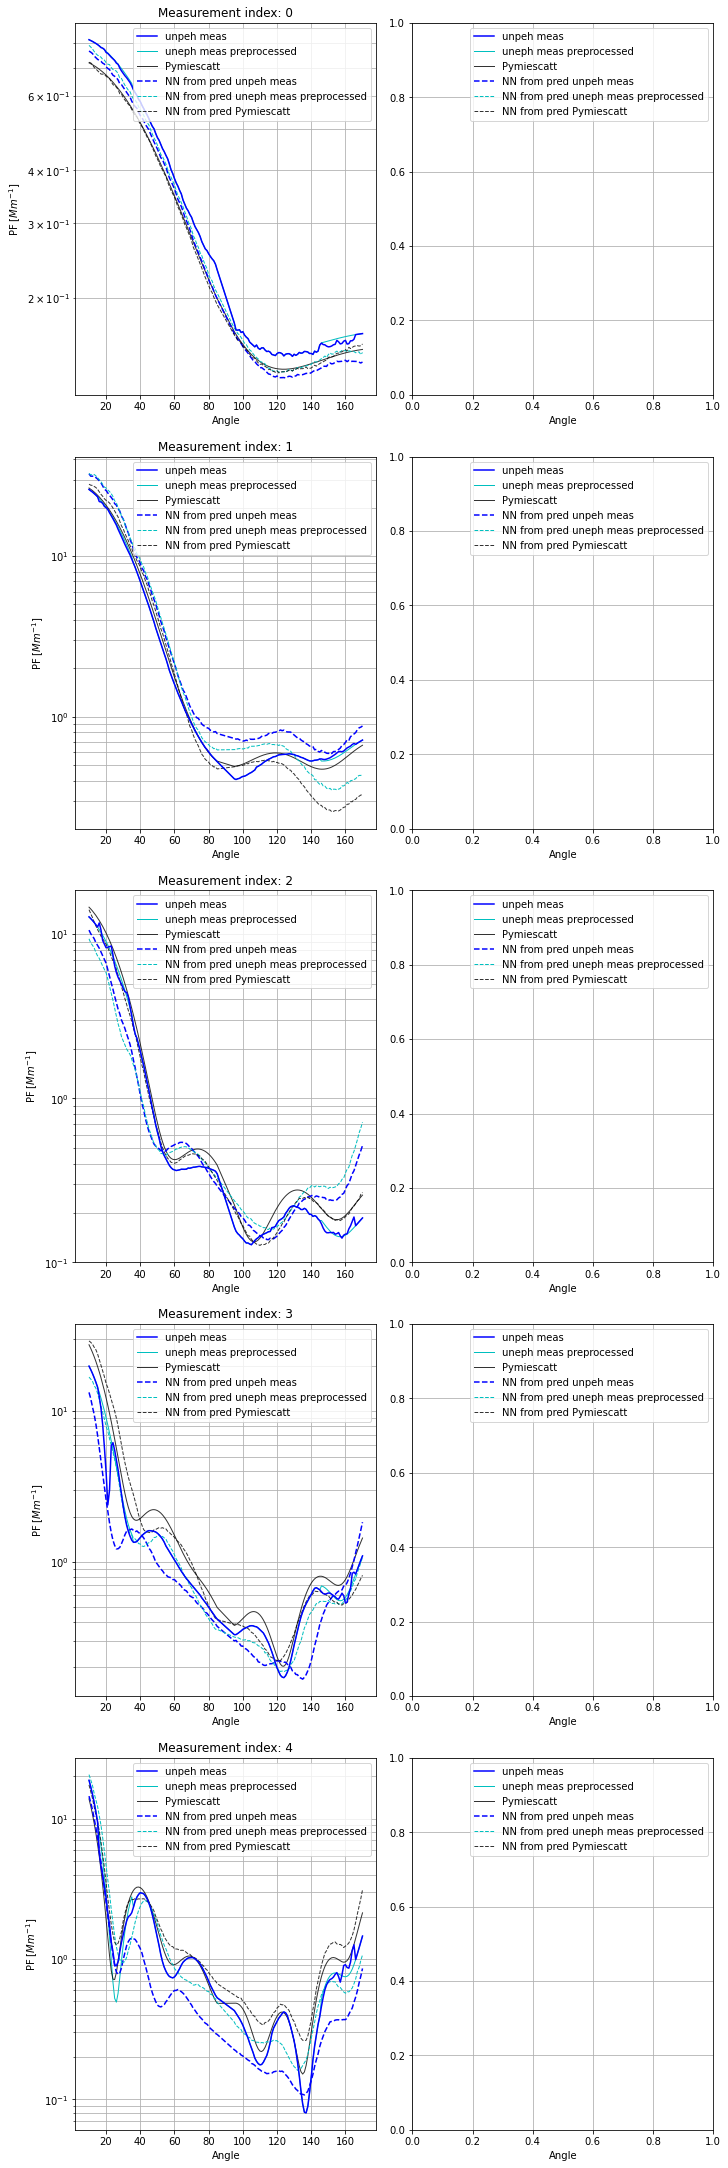

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


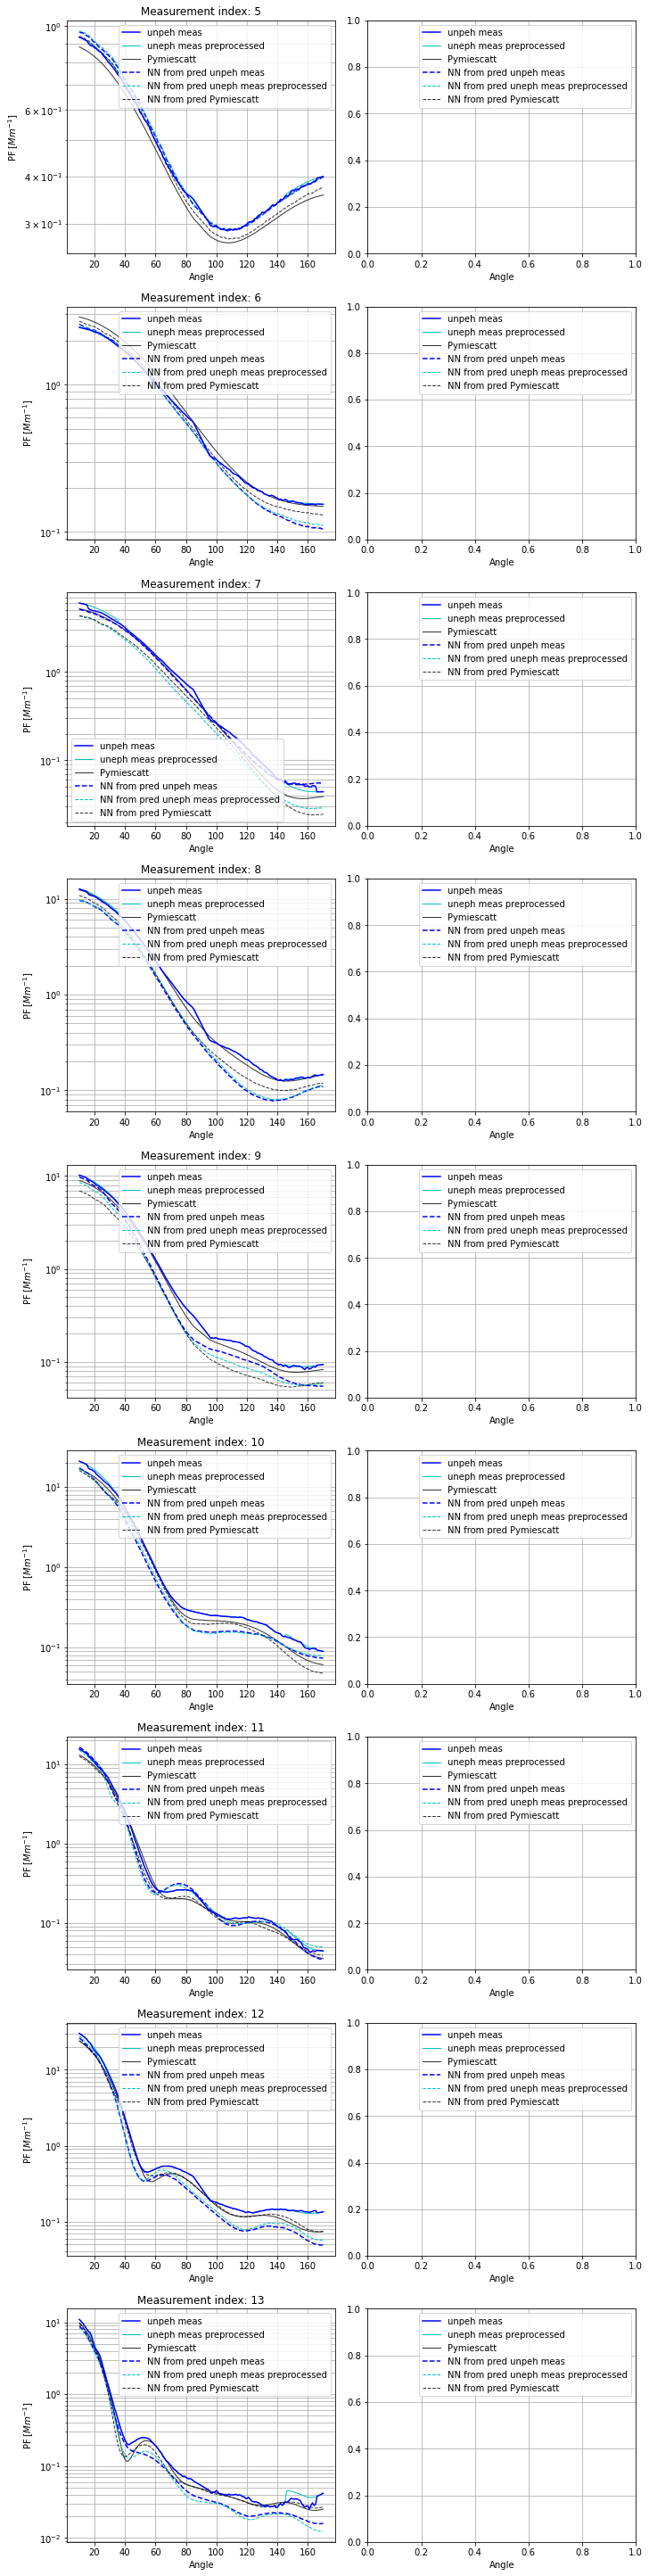

In [31]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [32]:
D_array = np.logspace(0.1, 5, 300)

In [33]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [34]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [35]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
#pms_qoi_meas_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

202.3566565213334
222.73262563494848
487.29793541703657
59.7874809596621
623.9758048148782
9.570229116028498
1008.7089793832126
6.290021449128849
1056.8019810492235
6.676127774759235
158.15252297753403
1170.9055388675233
239.81437089277102
264.06097273463456
284.99057297309884
185.09325162680804
349.88426568929725
169.06445713789643
399.2151464562832
72.96414728776764
468.5704854973886
85.41208295909372
572.8430338644827
28.520012537985597
658.3949377384984
31.398242308185186
776.0468741344865
6.712239057847416


In [36]:

# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

201.24536796687826
225.769029916619
482.6508646766631
61.97218236204937
608.3642418491874
10.082786155448764
784.1907661795113
9.068611069428158
947.8171746406725
10.894474889305602
158.34479963268407
1140.4809365605051
239.6779142206859
267.82509553212543
304.916825149891
127.32115672174963
345.8162333459842
173.962882070981
398.00629803718283
71.75416657527079
456.9732258009624
91.85690502842726
571.8172329083596
29.1280478882904
664.5985173531079
32.04201318138475
784.0786490971203
5.994351771377017


In [37]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

196.4672675357101
235.01285587258715
480.1969941114377
54.116438869303146
607.9001988526151
10.298490304341763
755.9750966534732
14.01440375980692
946.8198910819636
12.727542089986166
161.08940537980914
1002.3585971228556
238.57268878511118
300.062570272418
297.2612357547646
134.48701542507953
358.41220059868476
140.60932089370837
389.4522588953667
68.17268426080811
449.23592698520036
68.65695056533114
535.0548988110727
31.06601462511449
611.7062387258958
37.962288478115
798.2444156988314
7.210273705312494


In [32]:
# Calculate relative error for aerosol retrieval

def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

Vtot          10.207029
RmedianV       6.387951
GSD            2.623282
n              3.489549
k           6995.868339
dtype: float64
Vtot          12.459855
RmedianV       3.696789
GSD            2.075605
n              3.675749
k           5147.946478
dtype: float64
Vtot           7.969404
RmedianV       2.716324
GSD            1.091171
n              1.947410
k           6205.871198
dtype: float64


<ipython-input-32-8ee36c1ca767>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')
